In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch import optim
from torch import nn
from tqdm import tqdm

import tasks
import models
from helpers import *

In [12]:
#Alpha
model_alias = "alpha"
task_name = "TICT"
model, task, parameters = load_model(model_alias, task_name)

In [2]:
#Alpha new activation function
model_alias = "alpha"
task_name = "TICT"
model, task, parameters = load_model(model_alias, task_name)
model.S = models.double_softplus

C:\Users\user\OneDrive\Desktop\work\Recurrent-Neural-Networks-for-cognitive-tasks\helpers.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.lo

In [5]:
n_check = 10
n_epochs = 200 * 5 + 1
d1_max = 90
d2_max = 95
batch_size = parameters["batch_size"]
learning_rate = parameters["learning_rate"]
hidden_size = parameters["hidden_size"]

## Warm up


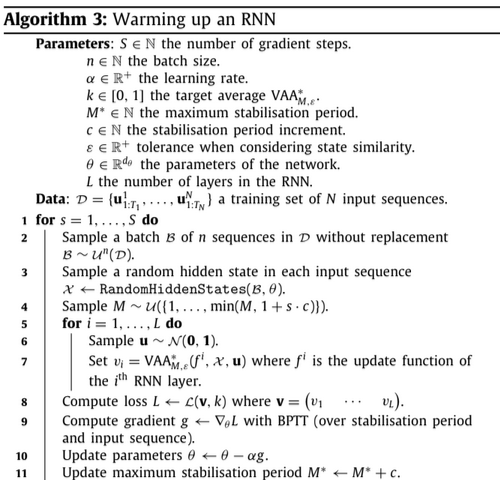

In [ ]:
def warm_up(model):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    c = 10
    M_star = 200
    k = torch.tensor(0.95)
    epsilon = 1e-3

    n_epochs_warmup = 100
    n_hidden_states = 32
    n_batch = int(n_hidden_states / 2)
    for s in tqdm(range(n_epochs_warmup)):
        inputs, labels, starts, ends, _, _  = task.get_random_trials(batch_size)
        data, targets = task.get_data(inputs, labels)

    # Sample X
    sampled_states = torch.zeros((n_hidden_states, hidden_size))
    for b in range(n_batch):
        _, hidden = model(data, ends, b)
        t = np.random.randint(ends[0, b], size = 2)
        sampled_states[b, :] = hidden[0, t[0], :]
        sampled_states[b + n_batch, :] = hidden[0, t[1], :]

    # Sample M
    M = np.random.choice(np.arange(1, min(M_star, 2 + s * c)))

    # Get VAA*
    f_M = torch.zeros(sampled_states.shape)
    for n in range(n_hidden_states):
        f_M[n, :] = model.simulate(sampled_states[n, :], M)

    v = VAA_star(f_M, epsilon)

    # Loss and gradient step
    loss = 0    
    loss = criterion(v, k)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

model_name = "Alpha_TICT_warmup2.txt"

In [ ]:
warm_up(model)

100%|██████████| 100/100 [07:40<00:00,  4.60s/it]


## Training

In [6]:
def train(model, save = False):
    criterion = nn.MSELoss(reduction="sum")
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_list = np.array([])
    produced_int = np.array([])
    correct_decision = np.array([])
    min_loss = 1e5

    for i in tqdm(range(1, n_epochs)):
        if i%n_check == 0:
            loss_list = np.append(loss_list, loss.detach().numpy())
            d1, d2 = check_accuracy(model)
            produced_int = np.append(produced_int, d1)
            correct_decision = np.append(correct_decision, d2)
            print(f" loss: {int(loss)} produced intervals: {d1:.2f}%; " \
                f"correct decisions: {d2:.2f}%")
            if save and int(loss) < min_loss:
                min_loss = int(loss)
                torch.save(model.state_dict(), model_name)
                if d1 > d1_max and d2 > d2_max:
                    print("success")
                    break

        inputs, labels, starts, ends, _, _  = task.get_random_trials(batch_size)
        data, targets = task.get_data(inputs, labels)
        loss = 0

        # forward
        for b in range(batch_size):
            scores, _ = model(data, ends, b)
            scores[0, :int(starts[0, b] - 1), :] *= 0
            loss += criterion(scores[0, :, :], targets[b, :int(ends[0, b]), :])

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent update step
        optimizer.step()

    return loss_list, produced_int, correct_decision

def check_accuracy(model):
    num_correct1 = 0
    num_correct2 = 0
    num_samples = 0

    model.eval()

    with torch.no_grad():
        for i in range(int(n_check / 5)):
            inputs, labels, starts, ends, Ts, obj = task.get_random_trials(batch_size)
            T5s = Ts[4, :]
            data, targets = task.get_data(inputs, labels)

            scores = torch.zeros(targets.shape)
            # forward
            for b in range(batch_size):
                scores1, _ = model(data, ends, b)
                scores1[0, :int(starts[0, b] - 1), :] *= 0
                scores[b, :int(ends[0, b]) , :] = scores1

            for b in range(batch_size):
                num_samples += 1
                ti = np.argmax(labels[b, :, int(obj[0,b])] > 0.5)

                if check_produced(scores, T5s, b, ti):
                    num_correct1 += 1
                    if torch.max(scores[b, ti:ti+15, int(obj[0, b])]) > 0.5:
                        num_correct2 += 1

    model.train()
    try:
        return num_correct1/num_samples*100, num_correct2/num_correct1*100
    except:
        return num_correct1/num_samples*100, 0


loss_list, produced_int, correct_decision = train(model, save=False)

  1%|▋                                                                              | 9/1000 [03:35<5:28:11, 19.87s/it]

 loss: 5233 produced intervals: 0.00%; correct decisions: 0.00%


  2%|█▍                                                                            | 19/1000 [06:55<5:01:25, 18.44s/it]

 loss: 354 produced intervals: 23.44%; correct decisions: 100.00%


  3%|██▎                                                                           | 29/1000 [10:52<5:26:07, 20.15s/it]

 loss: 433 produced intervals: 78.91%; correct decisions: 100.00%


  4%|███                                                                           | 39/1000 [14:00<4:45:40, 17.84s/it]

 loss: 375 produced intervals: 37.50%; correct decisions: 100.00%


  5%|███▊                                                                          | 49/1000 [17:04<4:49:11, 18.25s/it]

 loss: 220 produced intervals: 67.19%; correct decisions: 100.00%


  6%|████▌                                                                         | 59/1000 [20:43<6:11:40, 23.70s/it]

 loss: 179 produced intervals: 96.09%; correct decisions: 100.00%


  6%|████▉                                                                         | 64/1000 [23:04<5:37:26, 21.63s/it]


KeyboardInterrupt: 

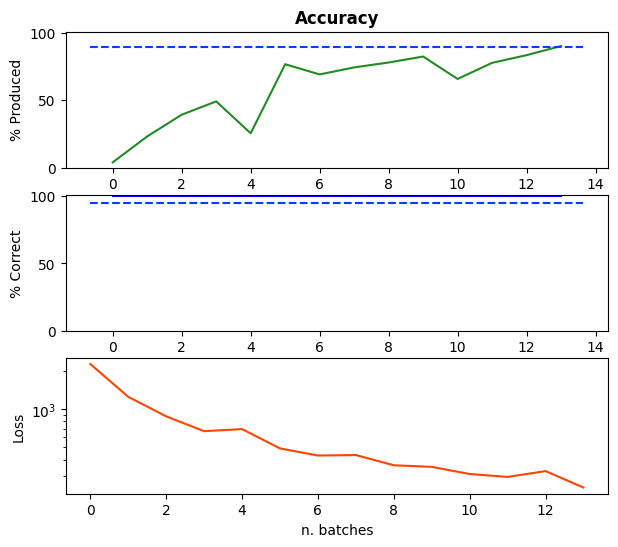

In [ ]:
plt.figure(figsize=(7,6))

plt.subplot(311)
plt.title("Accuracy", weight="bold")
plt.plot(produced_int, color="forestgreen")
axes = plt.gca()
xi, xs = axes.get_xlim()
plt.hlines(d1_max, xi, xs, linestyles="dashed")
plt.ylabel("% Produced")
plt.ylim([0, 101])

plt.subplot(312)
plt.plot(correct_decision, color="blue")
plt.hlines(d2_max, xi, xs, linestyles="dashed")
plt.ylim([0, 101])
plt.ylabel("% Correct")

plt.subplot(313)
plt.plot(loss_list, color="orangered")
plt.yscale("log")
plt.ylabel("Loss")
plt.xlabel("n. batches")
plt.show()

## Testing

In [6]:
inputs, labels, starts, ends, Ts, obj = task.get_random_trials(batch_size)
T2s = Ts[1, :]
T3s = Ts[2, :]
data, targets = task.get_data(inputs, labels)

with torch.no_grad():
    scores = torch.zeros(targets.shape)
    hidden = torch.zeros(batch_size, task.lentv, hidden_size)
    for b in range(batch_size):
        scores1, hidden1 = model(data, ends, b)
        hidden[b, :, :] = hidden1
        scores1[0, :int(starts[0, b] - 1), :] *= 0
        scores[b, :int(ends[0, b]), :] = scores1

n = 1

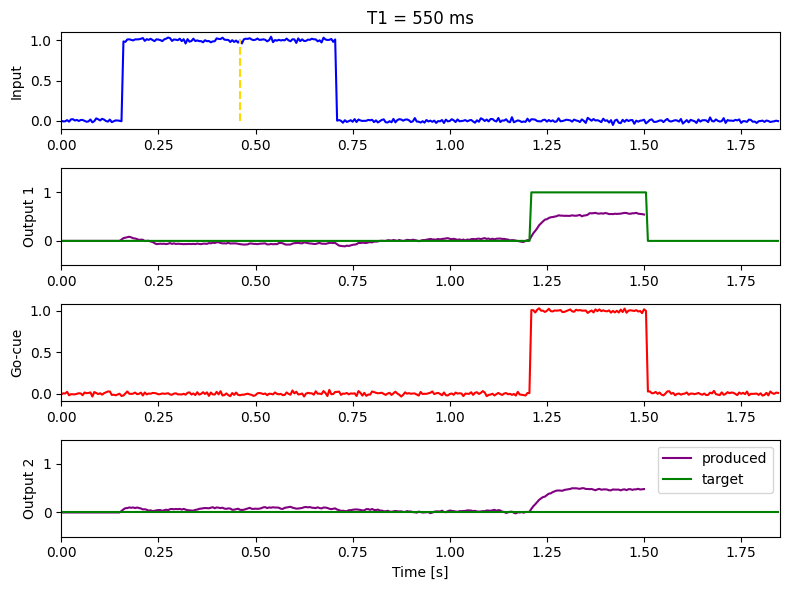

In [7]:
n += 1
title = "T1 = " + str(int(T2s[n] * task.step * 1e3)) + " ms"
task.plot_trial(scores, inputs, labels, starts, ends, n, title)

## Export

In [ ]:
# Create a file with the hidden activity of 400 trials (Hs) and the 
# information of those trials (Ts).

batch_size = 400

with torch.no_grad():
    inputs, labels, starts, ends, Ts, obj = get_random_trials()
    data, targets = get_data(inputs, labels)

    scores = torch.zeros(targets.shape)
    hiddens = torch.zeros(batch_size, len(tv), hidden_size)
    for b in range(batch_size):
        scores1, hidden1 = model(data, ends, b)
        hiddens[b, :, :] = hidden1
        scores1[0, :int(starts[0,b]-1), 0] *= 0
        scores[b, :int(ends[0,b]), :] = scores1

# Produce neu file
Hs = hiddens.detach().numpy() # e , t, neu
Hs = Hs.transpose(2,0,1).reshape(-1, len(tv)) # neu, e, t
np.savetxt("IC_neu_T4.txt", Hs)

# Produce info file
np.savetxt("IC_info_T4.txt", Ts)

In [7]:
# Save the model
model_name = "Alpha_TICT_doubleSP"
%cd saved_models/
torch.save(model.state_dict(), model_name)
%cd ..

C:\Users\user\OneDrive\Desktop\work\Recurrent-Neural-Networks-for-cognitive-tasks\saved_models
C:\Users\user\OneDrive\Desktop\work\Recurrent-Neural-Networks-for-cognitive-tasks
